In [ ]:
import torch
import torchvision
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [2]:
class Breeds(Dataset): 
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        
        self.breeds = sorted(os.listdir(root_dir))
        self.class_to_idx = {breed: idx for idx, breed in enumerate(self.breeds)}
        self.idx_to_class = {idx: breed for breed, idx in self.class_to_idx.items()}

        self.image_path = []
        self.labels = []

        for breed in self.breeds:
            breed_folder = os.path.join(root_dir, breed)
            if os.path.isdir(breed_folder):
                for img_name in os.listdir(breed_folder):
                    img_path = os.path.join(breed_folder, img_name)
                    self.image_path.append(img_path)
                    self.labels.append(self.class_to_idx[breed])

    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx):
        img_path = self.image_path[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transforms:
            image = self.transforms(image)

        return image, label
    
class BreedsFixed(Dataset):
    def __init__(self, image_paths, labels, transforms=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transforms
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [11]:
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomAffine(degrees=15, shear=15),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset = Breeds(root_dir='images\\Images\\')

In [5]:
all_images = dataset.image_path
all_labels = dataset.labels

train_imgs, test_imgs, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=1, stratify=all_labels)

train_dataset = BreedsFixed(train_imgs, train_labels, transforms=transforms_train)
test_dataset = BreedsFixed(test_imgs, test_labels, transforms=transforms_test)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_ds, valid_ds = random_split(train_dataset, [train_size, val_size])

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False)

test_dl = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
from torch.utils.tensorboard import SummaryWriter
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train(model, train_dl, valid_dl, num_epochs, loss_fn, optimizer):
    device = torch.device("cuda")
    model.to(device)

    scaler = GradScaler(device=device)
    torch.backends.cudnn.benchmark = True

    writer = SummaryWriter()
    scheduler = ReduceLROnPlateau(optimizer=optimizer, patience=2, factor=0.5)

    for epoch in range(num_epochs):
        model.train()
        total_samples_train = 0
        total_loss_train = 0
        total_correct_train = 0
        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast(device_type="cuda"):
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss_train += loss.item() * y_batch.size(0)
            total_correct_train += (torch.argmax(pred, dim=1) == y_batch).sum().item()
            total_samples_train += y_batch.size(0)
        
        train_loss = total_loss_train / len(train_dl.dataset)
        train_accuracy = total_correct_train / total_samples_train


        model.eval()

        total_correct_valid = 0
        total_samples_valid = 0
        total_loss_valid = 0

        with torch.inference_mode():
            for x_batch, y_batch in valid_dl:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                with autocast(device_type="cuda"):
                    pred = model(x_batch)
                    loss = loss_fn(pred, y_batch)

                total_loss_valid += loss.item() * y_batch.size(0)
                total_correct_valid += (torch.argmax(pred, dim=1) == y_batch).sum().item()
                total_samples_valid += y_batch.size(0)

        valid_loss = total_loss_valid / len(valid_dl.dataset)
        valid_accuracy = total_correct_valid / total_samples_valid

        scheduler.step(valid_loss)

        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Validation", valid_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_accuracy, epoch)
        writer.add_scalar("Accuracy/Valid", valid_accuracy, epoch)

        print(f'Epoch {epoch + 1}, train acc: {train_accuracy:.4f}, valid acc: {valid_accuracy:.4f}')

    writer.close()

In [8]:
from torchvision.models import efficientnet_b3

effnetb3 = efficientnet_b3(weights="DEFAULT")

effnetb3.classifier[1] = nn.Linear(1536, 120)


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb3.parameters(), lr=0.0001)

In [10]:
train(effnetb3, train_dl, valid_dl, num_epochs=7, loss_fn=loss_fn, optimizer=optimizer)

Epoch 1, train acc: 0.2815, valid acc: 0.6404
Epoch 2, train acc: 0.6754, valid acc: 0.7807
Epoch 3, train acc: 0.7699, valid acc: 0.8014
Epoch 4, train acc: 0.8129, valid acc: 0.8202
Epoch 5, train acc: 0.8451, valid acc: 0.8205
Epoch 6, train acc: 0.8675, valid acc: 0.8230
Epoch 7, train acc: 0.8910, valid acc: 0.8248


In [16]:
for param in effnetb3.features[-3:].parameters():
    param.requires_grad = True

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb3.parameters(), lr=2e-5, weight_decay=1e-4)

In [18]:
train(effnetb3, train_dl, valid_dl, num_epochs=2, loss_fn=loss_fn, optimizer=optimizer)

Epoch 1, train acc: 0.9266, valid acc: 0.8366
Epoch 2, train acc: 0.9287, valid acc: 0.8394


In [23]:
torch.save(effnetb3.state_dict(), "effnetb3.pt")

In [19]:
total_correct = 0
total_samples = 0

with torch.no_grad():
    effnetb3.eval()
    for x_batch, y_batch in test_dl:
        x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")
        pred = effnetb3(x_batch)

        total_correct += (torch.argmax(pred, dim=1) == y_batch).sum().item()
        total_samples += y_batch.size(0)  

accuracy_score = total_correct / total_samples  
print(f"Test Accuracy: {accuracy_score:.4f}")

        

Test Accuracy: 0.8452


In [20]:
import matplotlib.pyplot as plt

misclassified = []
misclassified_labels = []
true_labels = []

effnetb3.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")
        preds = effnetb3(x_batch)
        preds = torch.argmax(preds, dim=1)

        mask = preds != y_batch
        misclassified.extend(x_batch[mask].cpu())  
        misclassified_labels.extend(preds[mask].cpu().tolist())
        true_labels.extend(y_batch[mask].cpu().tolist())

print(f"Total misclassified samples: {len(misclassified)}")


Total misclassified samples: 637


In [21]:
class_names = []

for path in os.listdir("images\\Images"):
    class_names.append(path.split('-')[1])

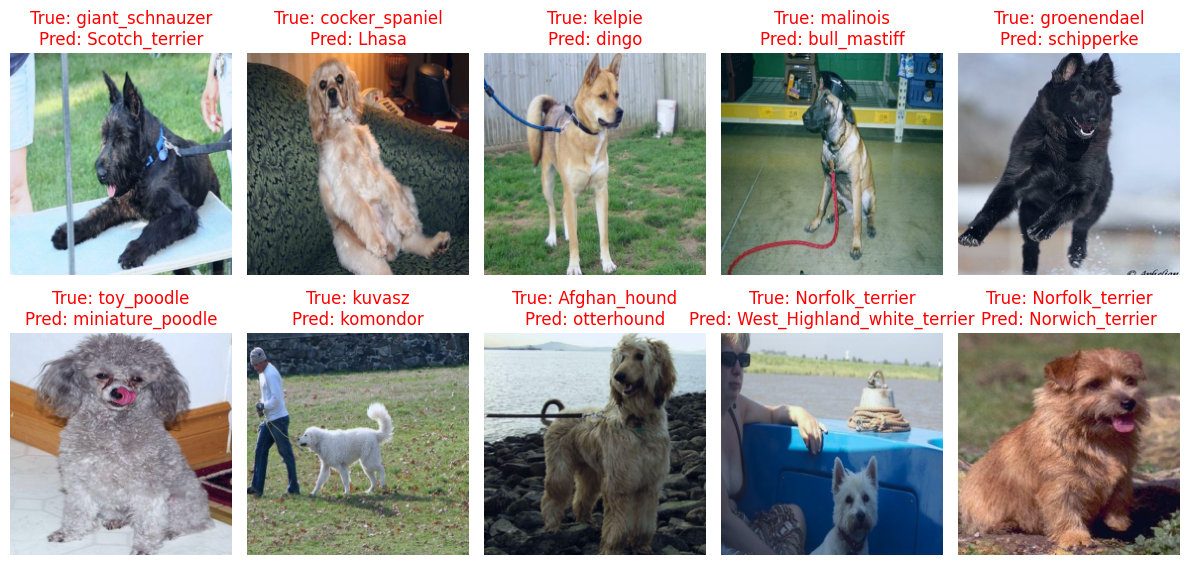

In [22]:
def show_misclassified(misclassified, true_labels, misclassified_labels, class_names, num=10):
    fig,axes = plt.subplots(2, 5, figsize=(12,6))
    axes = axes.flatten()

    for i in range(num):
        img = misclassified[i].permute(1, 2, 0).numpy()  
        img = (img - img.min()) / (img.max() - img.min()) 

        true_class = class_names[true_labels[i]]
        pred_class = class_names[misclassified_labels[i]]

        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_class}\nPred: {pred_class}", color='red')
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

show_misclassified(misclassified, true_labels, misclassified_labels, class_names)

In [ ]:
import torch
import torchvision.models as models

model = models.efficientnet_b3(weights=None)  

model.classifier[1] = torch.nn.Linear(in_features=1536, out_features=120)
model.load_state_dict(torch.load("effnetb3.pt"))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [43]:
class Test(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.tranform = transform
        self.filenames = os.listdir(root_dir)

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        label = 1 if "dog" in img_name else 0

        if self.tranform:
            image = self.tranform(image)

        return image, label

In [91]:
photo_test = Test("test/", transforms_test)

test_dl = DataLoader(photo_test, batch_size=16, shuffle=False)

In [ ]:
softmax = torch.nn.Softmax(dim=1)

for x_batch, y_batch in test_dl:
    x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")
    pred = model(x_batch)

    probabilities = softmax(pred)  
    top_probs, top_classes = torch.topk(probabilities, 3, dim=1) 

    for i in range(len(x_batch)):
        for j in range(3):  
            print(f"  {j+1}) {class_names[top_classes[i, j]]}: {top_probs[i, j].item():.4f}")
        print()


  1) otterhound: 0.9785
  2) Dandie_Dinmont: 0.0046
  3) briard: 0.0032

